In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.cnns import simple_cnn_bn
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from evaluation.metrics import categorical_accuracy, sensitivity_per_class, specificity_per_class


In [10]:
target_dir = '../test_files/EGGIMazing/Dataset'
model_weights_directory = '../logs/crossvalidation/temp_splits/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'cnn_basic_da_togasonly_cv_5fold_{num_folds}'
model_fold_dir = sorted([x for x in os.listdir(model_weights_directory) if x.startswith('cnn_basic_da_togasonly')])
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
              for x in model_fold_dir]

In [11]:
 model_dirs

['../logs/crossvalidation/temp_splits/cnn_basic_da_togasonly_cv_5fold_0_20240814-170548/weights.h5',
 '../logs/crossvalidation/temp_splits/cnn_basic_da_togasonly_cv_5fold_1_20240814-170727/weights.h5',
 '../logs/crossvalidation/temp_splits/cnn_basic_da_togasonly_cv_5fold_2_20240814-170908/weights.h5',
 '../logs/crossvalidation/temp_splits/cnn_basic_da_togasonly_cv_5fold_3_20240814-171055/weights.h5',
 '../logs/crossvalidation/temp_splits/cnn_basic_da_togasonly_cv_5fold_4_20240814-171224/weights.h5']

In [12]:
from sklearn.metrics import confusion_matrix

dp = DatasetProcessor(target_dir)
df = dp.process()
togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)

split = dp.group_k_splits(df_togas, k=num_folds, train_size=0.7, val_size=0.1, test_size=0.2, random_state=42)
metrics = []

for fold, (train_idx, val_idx, test_idx) in enumerate(split):
    tf_train_df = get_tf_eggim_patch_dataset(df_togas.loc[train_idx], num_classes=3)
    tf_val_df = get_tf_eggim_patch_dataset(df_togas.loc[val_idx], num_classes=3)
    tf_test_df = get_tf_eggim_patch_dataset(df_togas.loc[test_idx], num_classes=3)

    tf_train_df = tf_train_df.batch(batch_size)
    tf_val_df = tf_val_df.batch(batch_size)
    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have
    model = simple_cnn_bn(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'), Recall(name='recall'),
                           AUC(name='auc')])

    name_fold = name + f'fold_{fold}'

    model.load_weights(model_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred = model.predict(tf_test_df)
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal)
    metrics.append([categorical_accuracy(y_true, y_pred_one_hot),
                    specificity_per_class(conf_matrix), sensitivity_per_class(conf_matrix),
                    conf_matrix])

Metal device set to: Apple M1


2024-08-14 17:43:12.222712: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-14 17:43:12.222823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-14 17:43:12.671497: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-08-14 17:43:12.815861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s

2024-08-14 17:43:13.692373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s

2024-08-14 17:43:14.289111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/3 [===================>..........] - ETA: 0s

2024-08-14 17:43:15.053808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s

2024-08-14 17:43:15.630352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 80ms/step


In [13]:
cat_acc = np.array([x[0] for x in metrics])
spec = np.array([x[1] for x in metrics])
sens = np.array([x[2] for x in metrics])
confs = np.array([x[3] for x in metrics])

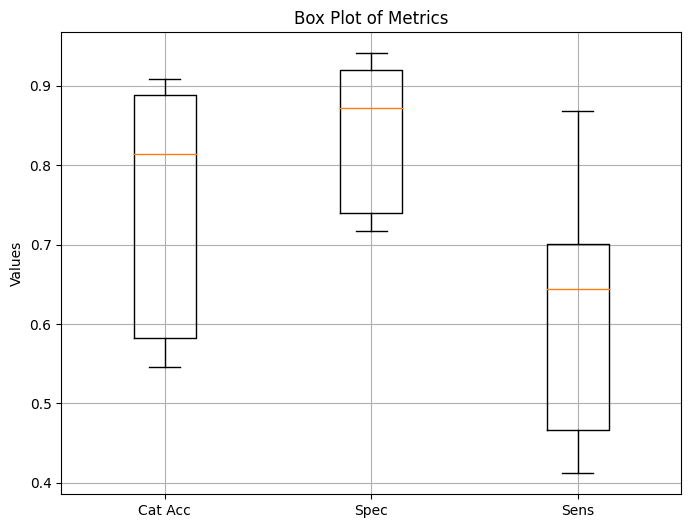

In [14]:
data = [cat_acc, np.mean(spec, axis=1), np.mean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

In [15]:
print("Mean metrics")
print(np.mean(data, axis=1))

Mean metrics
[0.74796192 0.83801398 0.61833892]


In [16]:
print("Specificity per 0,1,2")
print(np.mean(spec, axis=0))

print("Sensitivity per 0,1,2")
print(np.mean(sens, axis=0))

Specificity per 0,1,2
[0.59674534 0.93528078 0.98201581]
Sensitivity per 0,1,2
[0.97048128 0.36935065 0.51518482]


In [17]:
print(cat_acc) # cat_acc

[0.90909091 0.81428571 0.88888889 0.54545455 0.58208955]


In [18]:
print(spec) # sppec

[[0.81818182 0.96226415 0.97826087]
 [0.7        0.98484848 0.93181818]
 [0.87179487 0.95081967 1.        ]
 [0.40625    0.81355932 1.        ]
 [0.1875     0.96491228 1.        ]]


In [19]:
print(sens)

[[0.93181818 0.         1.        ]
 [0.95       0.5        0.65384615]
 [1.         0.81818182 0.78571429]
 [0.97058824 0.42857143 0.        ]
 [1.         0.1        0.13636364]]


In [20]:
print(confs)

[[[41  2  1]
  [ 2  0  0]
  [ 0  0  9]]

 [[38  0  2]
  [ 1  2  1]
  [ 8  1 17]]

 [[33  0  0]
  [ 2  9  0]
  [ 3  3 22]]

 [[33  1  0]
  [ 4  3  0]
  [15 10  0]]

 [[35  0  0]
  [ 9  1  0]
  [17  2  3]]]
